## Lab 2 - Genetic algorithm

**Autor: Marcin Zwierzchowski**

In [535]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial.distance import cdist
import time
from tqdm  import tqdm
import gc
import pandas as pd

## 1. Dane zadania i funkcja pomocnicza

In [442]:
cities = {
    "A": [0, 0],
    "B": [1, 3],
    "C": [2, 1],
    "D": [4, 6],
    "E": [5, 2],
    "F": [6, 5],
    "G": [8, 7],
    "H": [9, 4],
    "I": [10, 8],
    "J": [12, 3]
}
num_to_city = {i+1: city for i, city in enumerate(cities.keys())}
# num_to_city

In [444]:
coordinates = list(cities.values())
distance_matrix = cdist(coordinates, coordinates, metric='euclidean')
# distance_matrix


In [557]:
def calculate_runtime(algorithm, runs=10, print_output=False):
    measurements = []
    results = {}
    for _ in tqdm(range(runs)):
    # for _ in tqdm(runs):


        gc_old = gc.isenabled()
        gc.disable()
        start_time = time.process_time()
        best_individual, best_score = algorithm()
        end_time = time.process_time()
        if print_output:
            print(f"Best: {[num_to_city[ele] for ele in best_individual]} -> Score: {best_score:.3f}; Route length: {1/best_score:.3f}")
        if gc_old:
            gc.enable()
        measurements.append(end_time - start_time)
    
    results = {
        "Min": round(np.min(measurements), 2),
        "Avg": round(np.mean(measurements), 2),
        "Std": round(np.std(measurements), 2),
        "Max": round(np.max(measurements), 2)
    }

    return pd.DataFrame([results])

## 2. Implementacja algorytmu genetycznego

In [451]:
class GeneticAlgorithm:
    """
    Genetic Algorithm for solving the Traveling Salesman Problem (TSP).

    Parameters:
    - distance_matrix: 2D array representing distances between cities.
    - tmax (int): Maximum number of iterations (default: 50000).
    - Pm (float): Mutation probability (default: 0.6).
    - Pc (float): Crossover probability (default: 0.6).
    - pop_size (int): Population size (default: 5).
    - num_cities (int): Number of cities (default: 10).
    - selection_method (str): Selection method ('roulette' or 'tournament', default: 'roulette').
    """

    def __init__(self, distance_matrix, 
                 tmax = 1000, 
                 Pm = 0.1, Pc = 0.8, 
                 pop_size = 50, 
                 selection_method = "roulette",
                 verbose = False):
        
        self.tmax = tmax
        self.population = []
        self.Pm = Pm
        self.Pc = Pc
        self.pop_size = pop_size
        self.num_cities = distance_matrix.shape[0]
        self.distance_matrix = distance_matrix
        self.selection_method = selection_method
        self.verbose = verbose
        self._validate_parameters()

    def _validate_parameters(self):
    
        if not (0 <= self.Pm <= 1):
            raise ValueError("Mutation probability (Pm) must be between 0 and 1.")
        if not (0 <= self.Pc <= 1):
            raise ValueError("Crossover probability (Pc) must be between 0 and 1.")
        if self.pop_size <= 0:
            raise ValueError("Population size (pop_size) must be greater than 0.")
        if not isinstance(self.distance_matrix, (list, np.ndarray)):
            raise TypeError("Distance matrix must be a list or numpy array.")
        if self.selection_method not in ["roulette", "tournament"]:
            raise ValueError("Selection method must be 'roulette' or 'tournament'.")  
        if self.distance_matrix.shape[0] == 0:
            raise ValueError("Distance matrix must contain at least one city.") 
        if self.distance_matrix.shape[0] != self.distance_matrix.shape[1]:
            raise ValueError("Distance matrix must be square (same number of rows and columns).") 

    def initialize_population(self):

        for _ in range(self.pop_size):
            individual = random.sample(range(1,self.num_cities+1), self.num_cities)
            individual.append(individual[0])  # Ensure the last element is the same as the first
            self.population.append(individual)


    def run(self):

        t = 0 
        fitness_scores = self._evaluate_population(self.population) 
        best_score = max(fitness_scores)
        best_individual = self.population[fitness_scores.index(best_score)].copy()
        

        while(t < self.tmax):
            if self.verbose:
                print(f"------------------Iteration: {t+1}/{self.tmax}-------------------")
                print(f"Best individual: {best_individual} -> {best_score:.4f}. Route length: {1/best_score:.3f}")
                # for individual in self.population:
                #     print(individual)
            

            # Selection of individuals for reproduction
            if self.selection_method == "tournament":
                reproduction_pop = self._tournament_selection(self.population, fitness_scores)
            elif self.selection_method == "roulette":
                reproduction_pop = self._roulette_wheel_selection(self.population, fitness_scores) 

            crossovered_pop = self._crossover_population(reproduction_pop) # Crossover of individuals
            mutants_pop = self._mutation(crossovered_pop) # Mutation of individuals
             

            # Find the best individual in the current population
            fitness_scores = self._evaluate_population(mutants_pop)
            score = max(fitness_scores)
            individual = mutants_pop[fitness_scores.index(score)]
            
            # Update the best individual if the current one is better
            if score > best_score:
                best_score = score
                best_individual = individual
            
            self.population = mutants_pop
            t+=1
        return best_individual, float(best_score)
    

    def _fitness_fun(self,individual):
        
        total_dist = 0
        for n, _ in enumerate(individual[:-1]):
            total_dist += self.distance_matrix[individual[n]-1, individual[n+1]-1]
        return 1/total_dist
    

    def _evaluate_population(self, population):

        fitness_scores = []
        for individual in population:
            score = self._fitness_fun(individual)
            fitness_scores.append(score)
        return fitness_scores


    def _roulette_wheel_selection(self, population, fitness_scores):
        
        reproduction_pop = []
        total_fitness = sum(fitness_scores)

        for _ in range(self.pop_size): # Selection of the best individuals
            pick = random.uniform(0, total_fitness)
            current = 0

            # Selection of an individual based on probability. Individuals with higher fitness values have a greater chance of being selected.
            for i, fitness in enumerate(fitness_scores):
                current += fitness
                if pick <= current: 
                    # print(f"Selected individual no. {i}: {population[i]} -> {current - fitness :.1f} < {pick:.1f} < {current:.1f}")
                    reproduction_pop.append(population[i])
                    break
        return reproduction_pop


    def _tournament_selection(self, population, fitness_scores):
        
        reproduction_pop = []
        for _ in range(self.pop_size): 
            pick1 = random.randint(0, self.pop_size-1)
            pick2 = random.randint(0, self.pop_size-1)
            
            # print(f" {len(fitness_scores)} Selected individual numbers: {pick1}  {pick2}")

            if fitness_scores[pick1] > fitness_scores[pick2]:
                reproduction_pop.append(population[pick1])
            else:
                reproduction_pop.append(population[pick2])
        return reproduction_pop
        

    def _one_point_crossover(self, parent1, parent2):
        
        point = random.randint(1, len(parent1) - 2) 
        # Ensure the crossover point is not the first and not penultimate element or last one, 
        # because then it would give same parents.

        # print(f"Selected crossover point: {point}")

        child1 = parent1[:point]
        for gene in parent2:
            if gene not in child1:
                child1.append(gene)
        child1.append(child1[0])  # Ensure the first and last elements are the same

        child2 = parent2[:point]
        for gene in parent1:
            if gene not in child2:
                child2.append(gene)
        child2.append(child2[0])  # Ensure the first and last elements are the same

        return child1, child2
    

    def _crossover_population(self, population):

        new_population = []
        random.shuffle(population)

        for i in range(0, len(population) - 1, 2):  # Process pairs (0-1, 2-3, ...)
            parent1, parent2 = population[i], population[i + 1]
            
            if random.random() < self.Pc:  
                child1, child2 = self._one_point_crossover(parent1, parent2)
                new_population.extend([child1, child2])
            else:
                new_population.extend([parent1.copy(), parent2.copy()]) 

        # Case where the population size is odd
        if len(population) % 2 == 1:
            new_population.append(population[-1].copy())   

        return new_population


    def _mutation(self, population):
        mutated_population = []
        for individual in population:
            if random.random() < self.Pm:
                # print(f"Mutating individual: {individual}")
                mutated_population.append(self._swap_mutation(individual))
            else:
                mutated_population.append(individual)
        return mutated_population
    
    def _swap_mutation(self, route):
        #Random swap of two cities in the route, except for the first and last
        mutated_route = route[:]
        i, j = random.sample(range(1, len(route) - 1), 2)  
        mutated_route[i], mutated_route[j] = mutated_route[j], mutated_route[i]  
        assert mutated_route[0] == route[0] and mutated_route[-1] == route[-1]

        return mutated_route
    

## 3. Przykładowe użycie

### 3.1 Selekcja ruletkowa

In [579]:
runs = 10
tmax = 300

In [580]:
genetic_algorithm = GeneticAlgorithm(distance_matrix, 
                tmax = tmax, 
                Pm = 0.1, Pc = 0.8, 
                pop_size = 500, 
                selection_method = "roulette")
genetic_algorithm.initialize_population()
# genetic_algorithm.population
# print("Initial population:")
# for individual in genetic_algorithm.population:
#     print(individual)
# fit_scores = genetic_algorithm._evaluate_population()
# print("Fitness scores:", np.round(np.array(fit_scores), decimals=4))
# max(fit_scores)
# genetic_algorithm.mutation(genetic_algorithm.population)

# best_individual, best_score = genetic_algorithm.run()
# print(f"Best: {[num_to_city[ele] for ele in best_individual]} -> Score: {best_score:.3f}; Route length: {1/best_score:.3f}")

In [581]:
runtime = calculate_runtime(genetic_algorithm.run, runs=runs, print_output=True)
print(f"Runtime")
print(runtime)

 10%|█         | 1/10 [00:08<01:18,  8.76s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 20%|██        | 2/10 [00:17<01:08,  8.59s/it]

Best: ['J', 'I', 'G', 'F', 'D', 'B', 'A', 'C', 'E', 'H', 'J'] -> Score: 0.030; Route length: 33.123


 30%|███       | 3/10 [00:25<00:59,  8.56s/it]

Best: ['F', 'D', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'F'] -> Score: 0.028; Route length: 35.561


 40%|████      | 4/10 [00:32<00:47,  7.88s/it]

Best: ['F', 'H', 'J', 'I', 'G', 'D', 'B', 'C', 'A', 'E', 'F'] -> Score: 0.028; Route length: 35.331


 50%|█████     | 5/10 [00:39<00:37,  7.43s/it]

Best: ['F', 'D', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'F'] -> Score: 0.028; Route length: 35.561


 60%|██████    | 6/10 [00:45<00:27,  6.92s/it]

Best: ['F', 'D', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'F'] -> Score: 0.028; Route length: 35.561


 70%|███████   | 7/10 [00:51<00:20,  6.70s/it]

Best: ['F', 'D', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'F'] -> Score: 0.028; Route length: 35.561


 80%|████████  | 8/10 [00:57<00:13,  6.55s/it]

Best: ['F', 'H', 'J', 'I', 'G', 'D', 'B', 'C', 'A', 'E', 'F'] -> Score: 0.028; Route length: 35.331


 90%|█████████ | 9/10 [01:03<00:06,  6.34s/it]

Best: ['F', 'D', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'F'] -> Score: 0.028; Route length: 35.561


100%|██████████| 10/10 [01:09<00:00,  6.96s/it]

Best: ['F', 'D', 'B', 'A', 'C', 'E', 'H', 'J', 'I', 'G', 'F'] -> Score: 0.030; Route length: 33.123
Runtime
    Min   Avg   Std   Max
0  5.88  6.78  0.85  8.05


### 3.2 Selekcja turniejowa

In [582]:
genetic_algorithm = GeneticAlgorithm(distance_matrix, 
                tmax = tmax, 
                Pm = 0.1, Pc = 0.8, 
                pop_size = 500, 
                selection_method = "tournament")
genetic_algorithm.initialize_population()
# best_individual, best_score = genetic_algorithm.run()
# print(f"Best: {[num_to_city[ele] for ele in best_individual]} -> Score: {best_score:.3f}; Route length: {1/best_score:.3f}")

In [583]:
runtime = calculate_runtime(genetic_algorithm.run, runs=runs, print_output=True)
print(f"Runtime")
print(runtime)

 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

Best: ['B', 'D', 'F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B'] -> Score: 0.030; Route length: 33.123


 20%|██        | 2/10 [00:02<00:08,  1.06s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 30%|███       | 3/10 [00:03<00:07,  1.06s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 40%|████      | 4/10 [00:04<00:06,  1.15s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 50%|█████     | 5/10 [00:05<00:05,  1.15s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 70%|███████   | 7/10 [00:07<00:03,  1.12s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 80%|████████  | 8/10 [00:08<00:02,  1.12s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


 90%|█████████ | 9/10 [00:09<00:01,  1.09s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

Best: ['F', 'G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F'] -> Score: 0.030; Route length: 33.123
Runtime
    Min  Avg   Std   Max
0  1.03  1.1  0.07  1.28


### 3.2 Modyfikacja Pm

In [584]:
genetic_algorithm = GeneticAlgorithm(distance_matrix, 
                tmax = tmax, 
                Pm = 0.6, Pc = 0.8, 
                pop_size = 500, 
                selection_method = "roulette")
genetic_algorithm.initialize_population()

runtime = calculate_runtime(genetic_algorithm.run, runs=runs, print_output=True)
print(f"Runtime")
print(runtime)

 10%|█         | 1/10 [00:07<01:08,  7.65s/it]

Best: ['A', 'C', 'E', 'F', 'H', 'J', 'I', 'G', 'D', 'B', 'A'] -> Score: 0.029; Route length: 34.034


 20%|██        | 2/10 [00:14<00:56,  7.09s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123


 30%|███       | 3/10 [00:21<00:48,  6.97s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123


 40%|████      | 4/10 [00:28<00:41,  6.92s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123


 50%|█████     | 5/10 [00:34<00:34,  6.83s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123


 60%|██████    | 6/10 [00:42<00:28,  7.08s/it]

Best: ['I', 'G', 'F', 'D', 'B', 'A', 'C', 'E', 'H', 'J', 'I'] -> Score: 0.030; Route length: 33.123


 70%|███████   | 7/10 [00:48<00:20,  6.95s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123


 80%|████████  | 8/10 [00:56<00:14,  7.07s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123


 90%|█████████ | 9/10 [01:03<00:07,  7.25s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123


100%|██████████| 10/10 [01:10<00:00,  7.05s/it]

Best: ['G', 'I', 'J', 'H', 'E', 'C', 'A', 'B', 'D', 'F', 'G'] -> Score: 0.030; Route length: 33.123
Runtime
    Min  Avg   Std   Max
0  6.64  7.0  0.37  7.55


In [585]:
genetic_algorithm = GeneticAlgorithm(distance_matrix, 
                tmax = tmax, 
                Pm = 0.6, Pc = 0.8, 
                pop_size = 500, 
                selection_method = "tournament")
genetic_algorithm.initialize_population()

runtime = calculate_runtime(genetic_algorithm.run, runs=runs, print_output=True)
print(f"Runtime")
print(runtime)

 10%|█         | 1/10 [00:01<00:11,  1.27s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


 20%|██        | 2/10 [00:02<00:10,  1.29s/it]

Best: ['E', 'H', 'J', 'I', 'G', 'F', 'D', 'B', 'A', 'C', 'E'] -> Score: 0.030; Route length: 33.123


 30%|███       | 3/10 [00:04<00:09,  1.38s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


 40%|████      | 4/10 [00:05<00:08,  1.36s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


 50%|█████     | 5/10 [00:06<00:06,  1.37s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


 70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


 80%|████████  | 8/10 [00:11<00:02,  1.50s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


 90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

Best: ['E', 'C', 'A', 'B', 'D', 'F', 'G', 'I', 'J', 'H', 'E'] -> Score: 0.030; Route length: 33.123
Runtime
    Min   Avg   Std   Max
0  1.28  1.43  0.13  1.67


## 4. Results

| Selection| Pm       | Min      | Avg      | Std      | Max      | Exact solution |
|----------|----------|----------|----------|----------|----------|----------------|
| Ruletkowa| 0.1      | 4s       | 4.82s    | 0.58s    | 6.3s     |       3/10     |
|Turniejowa| 0.1      | 1.03s    | 1.1s     | 0.07s    | 1.28s    |       10/10    |
| Ruletkowa| 0.6      | 6.64s    | 7s       | 0.37s    | 7.55s    |       9/10     |
|Turniejowa| 0.6      | 1.28s    | 1.43s    | 0.13s    | 1.67s    |      10/10     |

Algorytm genetyczny zaimplementowany wraz z selekcja turniejowa jest szybsza oraz daje lepsze wyniki. W pierwszym przypadku 
algorytm wraz z selekcją ruletkową dał dokładne rozwiązanie 3 z 10 razy, gdzie algorytm wraz z selekcją turniejową (inne parametry takie same) dał 10/10 dokładnych rozwiązań i był przy tym szybszy średnio o 3s. Podobnie selekcja turniejowa ma przewagę dla większego prawdopodobieństwa mutacji = 0.6. Tu była szybsza o ponad 5s i dała lepsze wyniki, choć już nie tak znacząco. 
Zwiększanie prawdopodobieństwa mutacji zwiększa czas działania algorytmu, ale i poprawia szanse na osiągnięcia minimum globalnego. Widać to na przykładzie selekcji ruletkowej, która przy Pm = 0.1 znajdywała 3/10 minimum globalne, a dla Pm=0.6 już 10/10. Dzieje się to kosztem czasu działania algorytmu. 

## 5. Playground and testing

### Fitness function exercises

In [13]:
distance_matrix[1,2] +distance_matrix[2,6] + distance_matrix[6,5] + distance_matrix[5,1]

np.float64(18.934941283619054)

In [14]:
def fitness_fun(individual, distance_matrix):
    total_dist = 0
    for n in range(len(individual)-1):
        total_dist+= distance_matrix[individual[n],individual[n+1]]
    print(total_dist)

fitness_fun([1,2,6,5,1],distance_matrix)
# distance_matrix

18.934941283619054


In [ ]:
[random.sample(range(10), 10) for _ in range(5)]

[[4, 7, 3, 1, 0, 9, 5, 6, 8, 2],
 [2, 5, 6, 3, 8, 0, 9, 7, 1, 4],
 [8, 7, 3, 5, 1, 4, 6, 0, 9, 2],
 [8, 7, 4, 2, 5, 1, 6, 9, 3, 0],
 [9, 2, 8, 3, 7, 0, 5, 1, 4, 6]]

### Roulette wheel selection exercises

In [82]:
for i, individual in enumerate(genetic_algorithm.population):
    print(f"Osobnik {i}: {individual} - Score: {fit_scores[i] :.4f}")

def roulette_wheel_selection(population, fitness_values):
    total_fitness = sum(fitness_values)
    pick = random.uniform(0, total_fitness)
    current = 0

    for i, fitness in enumerate(fitness_values):
        current += fitness
        if pick <= current: 
            print(f"Wybrany osobnik nr. {i}: {population[i]} -> {current - fitness :.4f} < {pick:.4f} < {current:.4f}")
            return i,population[i]
    raise ValueError("Nie udało się wybrać osobnika (błąd w danych?)")

roulette_wheel_selection(genetic_algorithm.population, fit_scores)

# Testowanie funkcji selekcji ruletki z rysowaniem histogramu
test = []
for i in range(10):
    idx,_ = roulette_wheel_selection(genetic_algorithm.population, fit_scores)
    test.append(idx)

plt.hist(test)
# test

Osobnik 0: [9, 7, 2, 1, 5, 3, 4, 6, 8, 0, 9] - Score: 0.0203
Osobnik 1: [9, 7, 1, 5, 6, 4, 8, 3, 2, 0, 9] - Score: 0.0171
Osobnik 2: [9, 7, 2, 1, 0, 3, 5, 6, 8, 4, 9] - Score: 0.0169
Osobnik 3: [9, 7, 6, 1, 0, 3, 5, 2, 8, 4, 9] - Score: 0.0159
Wybrany osobnik nr. 0: [9, 7, 2, 1, 5, 3, 4, 6, 8, 0, 9] -> 0.0000 < 0.0189 < 0.0203


IndexError: list index out of range

### Crossover exercises

In [15]:
"""działa też okej ,ale jakby usnąć parent2[:-1] to już może generować za duzcyh rodziców. Prblem w tym, że tworząc tą listę
[gene for gene in parent2 if gene not in parent1[:point]]  (bez [:-1])
możemy wziąć dwa razy ten sam gen z parent2. Bo np 3, które jest na początku i końcu nie będzie jeszcze w parent1[:point]. Dlatego dodajemy [:-1] aby nie brać ostatniego elementu
Ale czytelniej jest użyć rozwiązania jedneg z poniżej.
"""

def crossover(parent1, parent2,Pr = 0.9):
        if random.random() < Pr:  # Zwykle 80% szans
            # Wykonaj krzyżowanie (np. jednopunktowe dla TSP)

            point = random.randint(1, len(parent1) - 1)  # Punkt krzyżowania (nie może być pierwszy ani ostatni)
            print(f"Wybrany punkyt krzyżowania {point}")
            # Krzyżowanie jednopunktowe z uwzględnieniem unikalności genów i pierwszego i ostatniego elementu równego sobie
            child1 = parent1[:point] + [gene for gene in parent2[:-1] if gene not in parent1[:point]] + [parent1[0]] 
            child2 = parent2[:point] + [gene for gene in parent1[:-1] if gene not in parent2[:point]] + [parent2[0]]
            assert parent1 != parent2, "Rodzice nie mogą być tacy sami"
            return child1, child2
        else:
            # Brak krzyżowania – zwróć rodziców
            return parent1.copy(), parent2.copy()  # Kopie, aby uniknąć mutacji oryginałów
crossover([8,2,3,1,6,7,5,4,8],[3,5,8,2,1,4,6,7,3])

Wybrany punkyt krzyżowania 1


([8, 3, 5, 2, 1, 4, 6, 7, 8], [3, 8, 2, 1, 6, 7, 5, 4, 3])

In [17]:
import random
def one_point_crossover(parent1, parent2, Pr=1):
    if random.random() < Pr:  # Perform crossover with probability Pr
        point = random.randint(1, len(parent1) - 2) # Ensure the crossover point is not the first and not penultimate element or last one,because then it would give same parents.
        print(f"Wybrany punkt krzyżowania: {point}")

        # Create child1
        child1 = parent1[:point]
        for gene in parent2:
            if gene not in child1:
                child1.append(gene)
        child1.append(child1[0])  # Ensure the first and last elements are the same

        # Create child2
        child2 = parent2[:point]
        for gene in parent1:
            if gene not in child2:
                child2.append(gene)
        child2.append(child2[0])  # Ensure the first and last elements are the same
        
        return child1, child2
    else:
        # No crossover, return copies of parents
        return parent1.copy(), parent2.copy()

# Example usage
child1, child2 = one_point_crossover([8,2,3,1,6,7,5,4,8],[3,5,8,2,1,4,6,7,3])
print("Child 1:", child1)
print("Child 2:", child2)

Wybrany punkt krzyżowania: 5
Child 1: [8, 2, 3, 1, 6, 5, 4, 7, 8]
Child 2: [3, 5, 8, 2, 1, 6, 7, 4, 3]


### Exact solution

In [218]:
import numpy as np
from itertools import permutations

cities = {
    "1": [0, 0],
    "2": [1, 3],
    "3": [2, 1],
    "4": [4, 6],
    "5": [5, 2],
    "6": [6, 5],
    "7": [8, 7],
    "8": [9, 4],
    "9": [10, 8],
    "10": [12, 3]
}

# Oblicz macierz odległości
def compute_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    city_ids = list(cities.keys())
    for i in range(n):
        for j in range(n):
            if i != j:
                x1, y1 = cities[city_ids[i]]
                x2, y2 = cities[city_ids[j]]
                dist_matrix[i][j] = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist_matrix, city_ids

distance_matrix, city_ids = compute_distance_matrix(cities)

In [229]:
def exact_tsp_solution(distance_matrix, city_ids):
    n = len(city_ids)
    best_distance = float('inf')
    best_route = None
    
    # Generuj wszystkie permutacje (bez powtórzeń i z powrotem do startu)
    for perm in permutations(range(1, n)):
        current_route = [0] + list(perm) + [0]  # Start i koniec w mieście 0 (indeks)
        current_distance = sum(
            distance_matrix[current_route[i]][current_route[i + 1]] 
            for i in range(n)
        )
        
        if current_distance < best_distance:
            best_distance = current_distance
            best_route = current_route
    
    # Mapuj indeksy na nazwy miast
    best_route_named = [city_ids[i] for i in best_route]
    return best_route_named, best_distance

# Uruchomienie
optimal_route, optimal_distance = exact_tsp_solution(distance_matrix, city_ids)
print("Optymalna trasa:", optimal_route)
print(f"Optymalna odległość: {optimal_distance:.3f}")
# optimal_distance

Optymalna trasa: ['1', '2', '4', '6', '7', '9', '10', '8', '5', '3', '1']
Optymalna odległość: 33.123


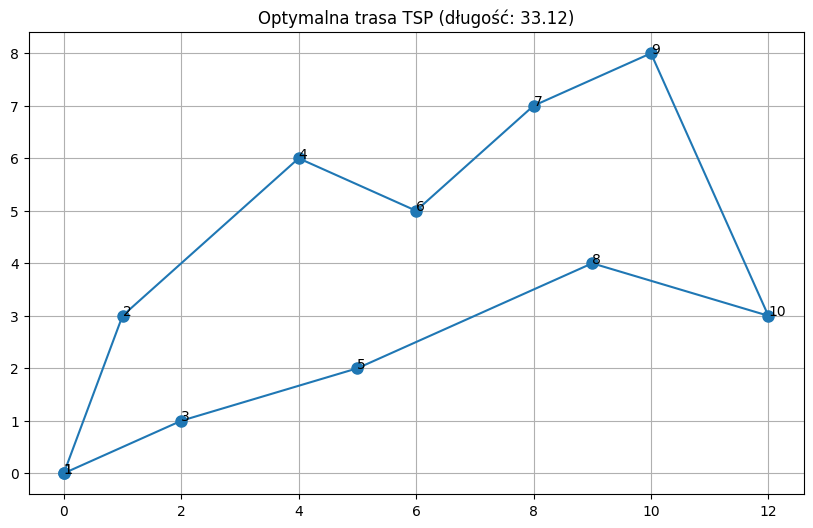

In [233]:
import matplotlib.pyplot as plt

def plot_route(cities, route):
    x = [cities[city][0] for city in route]
    y = [cities[city][1] for city in route]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'o-', markersize=8)
    for city in route:
        plt.text(cities[city][0], cities[city][1], city, fontsize=10)
    plt.title(f"Optymalna trasa TSP (długość: {optimal_distance:.2f})")
    plt.grid()
    plt.show()

plot_route(cities, optimal_route)